<a href="https://colab.research.google.com/github/AsutoshSatapathy/LearningAModel/blob/main/distribute_complexity_and_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation and Regularization



In [1]:
!git init; git pull https://github.com/AsutoshSatapathy/LearningAModel.git

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 1), reused 54 (delta 1), pack-reused 0
Unpacking objects: 100% (54/54), done.
From https://github.com/AsutoshSatapathy/LearningAModel
 * branch            HEAD       -> FETCH_HEAD


In [2]:
!ls

complexity_and_validation.ipynb		    noiseless_learning.ipynb
data					    noisylearning.ipynb
distribute_complexity_and_validation.ipynb  README.md
images					    sample_data
lecture.pdf				    testingtraining.ipynb


In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## PART 1: Reading in and sampling from the data

In [5]:
df=pd.read_csv("data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In [6]:
x=df.f.values
f=df.x.values
y = df.y.values

In [7]:
df.shape

(200, 3)

From 200 points on this curve, we'll make a random choice of 60 points. We do it by choosing the indexes randomly, and then using these indexes as a way of grtting the appropriate samples

In [8]:
indexes=np.sort(np.random.choice(x.shape[0], size=60, replace=False))
indexes

array([  1,   3,   7,   8,  10,  11,  12,  17,  23,  28,  29,  32,  39,
        42,  44,  46,  48,  51,  60,  65,  71,  73,  81,  88,  92,  93,
        96, 101, 102, 105, 106, 108, 111, 112, 114, 117, 120, 125, 127,
       128, 129, 131, 132, 134, 137, 140, 143, 145, 153, 156, 157, 166,
       171, 175, 179, 181, 184, 185, 195, 198])

In [9]:
samplex = x[indexes]
samplef = f[indexes]
sampley = y[indexes]

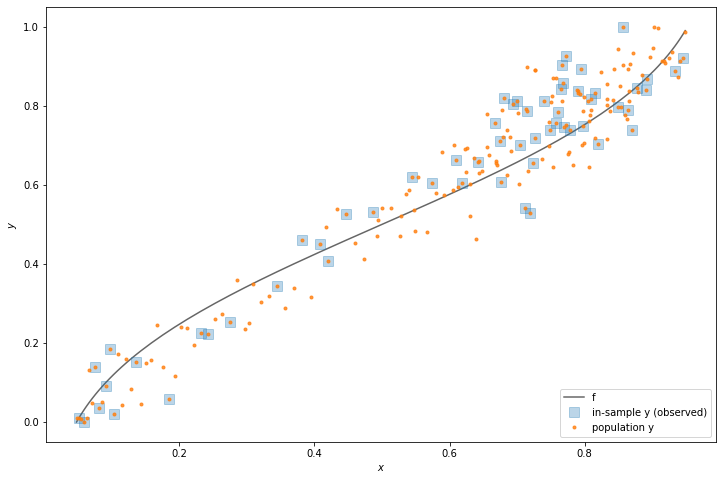

In [11]:
plt.figure(figsize=(12,8))
plt.plot(x,f, 'k-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.3, ms=10, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.8, label="population y");
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.legend(loc=4);

In [12]:
sample_df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

## Part 2: Fit on training set and predict on test set

We will do the split of testing and training for you in order to illustrate how this can be done.

### Train-test split

In [23]:
from sklearn.model_selection import train_test_split
datasize=sample_df.shape[0]
print(datasize)
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(np.arange(60),train_size=0.8)
print(itrain.shape)
xtrain= sample_df.x[itrain].values
ftrain = sample_df.f[itrain].values
ytrain = sample_df.y[itrain].values
xtest= sample_df.x[itest].values
ftest = sample_df.f[itest].values
ytest = sample_df.y[itest].values

60
(48,)


In [15]:
sample_df.x[itrain].values

array([0.6761895 , 0.44696488, 0.05119945, 0.84900884, 0.86448901,
       0.76022444, 0.89127429, 0.09680048, 0.87686794, 0.10263725,
       0.69392487, 0.94520071, 0.0758813 , 0.89202872, 0.77269819,
       0.76481781, 0.64194867, 0.85693881, 0.72340202, 0.71435176,
       0.23167757, 0.77836014, 0.76832243, 0.71947384, 0.66761369,
       0.13566606, 0.70051549, 0.67525289, 0.9331928 , 0.75803635,
       0.34457826, 0.70438695, 0.42074029, 0.61791142, 0.40775129,
       0.48670439, 0.80873507, 0.82017586, 0.79758014, 0.18406013,
       0.27425312, 0.76641959, 0.81593987, 0.73976678, 0.38208858,
       0.76954353, 0.79483368, 0.68095955])

We'll need to create polynomial features, ie add 1, x, x^2 and so on.

### The `scikit-learn` interface

Scikit-learn is the main python machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in python by the incantation `import sklearn`.

The library has a very well defined interface. This makes the library a joy to use, and surely contributes to its popularity. As the [scikit-learn API paper](http://arxiv.org/pdf/1309.0238v1.pdf) [Buitinck, Lars, et al. "API design for machine learning software: experiences from the scikit-learn project." arXiv preprint arXiv:1309.0238 (2013).] says:

>All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: **an estimator interface for building and ﬁtting models, a predictor interface for making predictions and a transformer interface for converting data**. The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators.

We'll use the "estimator" interface here, specifically the estimator `PolynomialFeatures`. The API paper again:

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a transformer interface which deﬁnes a transform method. It takes as input some new data X and yields as output a transformed version of X. Preprocessing, feature selection, feature extraction and dimensionality reduction algorithms are all provided as transformers within the library.

To start with we have one **feature** `x` to predict `y`, what we will do is the transformation:

$$ x \rightarrow 1, x, x^2, x^3, ..., x^d $$

for some power $d$. Our job then is to **fit** for the coefficients of these features in the polynomial

$$ a_0 + a_1 x + a_2 x^2 + ... + a_d x^d. $$

In other words, we have transformed a function of one feature, into a (rather simple) **linear** function of many features. To do this we first construct the estimator as `PolynomialFeatures(d)`, and then transform these features into a d-dimensional space using the method `fit_transform`.

![fit_transform](https://github.com/AsutoshSatapathy/LearningAModel/blob/main/images/sklearntrans.jpg?raw=1)

Here is an example. The reason for using `[[1],[2],[3]]` as opposed to `[1,2,3]` is that scikit-learn expects data to be stored in a two-dimensional array or matrix with size `[n_samples, n_features]`.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
PolynomialFeatures(2).fit_transform(xtrain)

In [18]:
np.array([1,2,3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

To transform `[1,2,3]` into [[1],[2],[3]] we need to do a reshape.

![reshape](https://github.com/AsutoshSatapathy/LearningAModel/blob/main/images/reshape.jpg?raw=1)

In [19]:
xtest.reshape(-1,1)

array([[0.71136277],
       [0.57373609],
       [0.54481073],
       [0.08075666],
       [0.09121122],
       [0.05859631],
       [0.7260675 ],
       [0.78935804],
       [0.74919957],
       [0.24196365],
       [0.60942486],
       [0.8695251 ]])

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [28]:
PolynomialFeatures(3).fit_transform(xtest)

ValueError: ignored

In [ ]:
PolynomialFeatures(3).fit_transform(xtest.reshape(-1,1))

### Creating Polynomial features

We'll write a function to encapsulate what we learnt about creating the polynomial features.

In [36]:
def make_features(train_set, test_set, degrees):
    train_dict = {}
    test_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
    return train_dict, test_dict

### Doing the fit

We first create our features, and some arrays to store the errors.

In [35]:
degrees=range(21)
train_dict, test_dict = make_features(xtrain, xtest, degrees)

In [33]:
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

What is the fitting process? We first loop over all the **hypothesis set**s that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. That is we start with ${\cal H_0}$, the set of all 0th order polynomials, then do ${\cal H_1}$, then ${\cal H_2}$, and so on... We use the notation ${\cal H}$ to indicate a hypothesis set. Then for each degree $d$, we obtain a best fit model. We then "test" this model by predicting on the test chunk, obtaining the test set error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the test set errors, and pick the degree $d_*$ and the model in ${\cal H_{d_*}}$ which minimizes this test set error.

>**YOUR TURN HERE**: For each degree d, train on the training set and predict on the test set. Store the training MSE in `error_train` and test MSE in `error_test`.

In [40]:
#for each degree, we now fit on the training set and predict on the test set
#we accumulate the MSE on both sets in error_train and error_test
for d in degrees:#for increasing polynomial degrees 0,1,2...
    Xtrain = train_dict[d]
    Xtest = test_dict[d]
    #set up model
    est = LinearRegression()
    #fit
    est.fit(Xtrain, ytrain)
    #predict
    #your code here
    predict_train = est.predict(Xtrain)
    predict_test = est.predict(Xtest)
    error_train[d] = mean_squared_error(ytrain, predict_train)
    error_test[d] = mean_squared_error(ytest, predict_test)

We can find the best degree thus:

In [ ]:
bestd = np.argmin(error_test)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(bestd, 0,0.5, color='r', label="min test error at d=%d"%bestd, alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

![m:caption](https://github.com/AsutoshSatapathy/LearningAModel/blob/main/images/complexity-error-plot.png?raw=1)

## Validation

What we have done in picking a given $d$ as the best hypothesis is that we have used the test set as a training set. 
If we choose the best $d$ based on minimizing the test set error, we have then "fit for" hyperparameter $d$ on the test set. 

In this case, the test-set error will underestimate the true out of sample error. Furthermore, we have **contaminated the test set** by fitting for $d$ on it; it is no longer a true test set.

Thus, we introduce a new **validation set** on which the complexity parameter $d$ is fit, and leave out a test set which we can use to estimate the true out-of-sample performance of our learner. The place of this set in the scheme of things is shown below:

![m:caption](https://github.com/AsutoshSatapathy/LearningAModel/blob/main/images/train-validate-test.png?raw=1)

We have split the old training set into a **new smaller training set** and a **validation set**, holding the old test aside for FINAL testing AFTER we have "fit" for complexity $d$. Obviously we have decreased the size of the data available for training further, but this is a price we must pay for obtaining a good estimate of the out-of-sample risk $\cal{E}_{out}$ (also denoted as risk $R_{out}$) through the test risk $\cal{E}_{test}$ ($R_{test}$).

![m:caption](https://github.com/AsutoshSatapathy/LearningAModel/blob/main/images/train-validate-test-cont.png?raw=1)

The validation process is illustrated in these two figures. We first loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. Then for each degree $d$, we obtain a best fit model $g^-_d$ where the "minus" superscript indicates that we fit our model on the new training set which is obtained by removing ("minusing") a validation chunk (often the same size as the test chunk) from the old training set. We then "test" this model on the validation chunk, obtaining the validation error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the validation set errors, just like we did with the test errors earlier, and pick the degree $d_*$ which minimizes this validation set error.

![caption](https://github.com/AsutoshSatapathy/LearningAModel/blob/main/images/train-validate-test3.png?raw=1)

Having picked the hyperparameter $d_*$, we retrain using the hypothesis set $\cal{H}_{*}$ on the entire old training-set to find the parameters of the polynomial of order $d_*$ and the corresponding best fit hypothesis $g_*$. Note that we left the minus off the $g$ to indicate that it was trained on the entire old traing set. We now compute the test error on the test set as an estimate of the test risk $\cal{E}_{test}$.

Thus the **validation** set if the set on which the hyperparameter is fit. This method of splitting the data $\cal{D}$ is called the **train-validate-test** split.

### Fit on training and predict on validation


We carry out this process for one training/validation split below. Note the smaller size of the new training set. We hold the test set at the same size.

In [ ]:
#we split the training set down further
intrain,invalid = train_test_split(itrain,train_size=36, test_size=12)
# why not just use xtrain, xtest here? its the indices we need. How could you use xtrain and xtest?
xntrain= sample_df.x[intrain].values
fntrain = sample_df.f[intrain].values
yntrain = sample_df.y[intrain].values
xnvalid= sample_df.x[invalid].values
fnvalid = sample_df.f[invalid].values
ynvalid = sample_df.y[invalid].values

degrees=range(21)
train_dict, valid_dict = make_features(xntrain, xnvalid, degrees)


>YOUR TURN HERE: Train on the smaller training set. Fit for d on the validation set.  Store the respective MSEs in `error_train` and `error_valid`. Then retrain on the entire training set using this d. Label the test set MSE with the variable `err`.

In [ ]:
error_train=np.empty(len(degrees))
error_valid=np.empty(len(degrees))
#for each degree, we now fit on the smaller training set and predict on the validation set
#we accumulate the MSE on both sets in error_train and error_valid
#we then find the degree of polynomial that minimizes the MSE on the validation set.
#your code here


In [ ]:
#calculate the degree at which validation error is minimized
mindeg = np.argmin(error_valid)
mindeg

In [ ]:
#fit on WHOLE training set now. 
##you will need to remake polynomial features on the whole training set
#Put MSE on the test set in variable err.
#your code here


We plot the training error and validation error against the degree of the polynomial, and show the test set error at the $d$ which minimizes the validation set error.

In [ ]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_valid, marker='o', label='validation')
plt.plot([mindeg], [err], marker='s', markersize=10, label='test', alpha=0.5, color='r')
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")
print(mindeg)

> YOUR TURN HERE: Run the set of cells for the validation process again and again. What do you see? The validation error minimizing polynomial degree might change! What happened?
